# 1. Problem Statement 
Building a model to predict whether an applicant's loan will be approved or not (Basically a Classification Problem).

# 2. Importing

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [7]:
# loading datasets
train=pd.read_csv(r"C:\Users\rakes\Desktop\analytics\Projects\Loan Prediction Using Random Forest\Data\train.csv" )

test=pd.read_csv(r"C:\Users\rakes\Desktop\analytics\Projects\Loan Prediction Using Random Forest\Data\test.csv")

Let’s make a copy of the train and test data so that even if we have to make any changes in these datasets we would not lose the original datasets.

In [8]:
train_copy=train.copy()
test_copy=test.copy()

It is generally a good idea to combine both train and test data sets into one then perform feature engineering and then divide them later again. This saves the trouble of performing the same steps of FE twice on test and train.

Lets combine them into a dataframe ‘data’ with a ‘source’ column specifying where each observation belongs.So,that it is easy to divide train and test later.

In [112]:
#combining train and test datas
train['source']='train'
test['source']='test'
data=pd.concat([train,test],ignore_index=True)
data.head()

#Dependents--no.of family candidates depending on that person

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,train
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,train
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,train
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,train
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,train


Looking at data we can say that we should standardize the data to same scale or use models which don't need of standardization like RF,XGBoost,SVM etc.,.

# 3. Data Exploration

In [5]:
data.shape, train.shape, test.shape

((981, 14), (614, 14), (367, 13))

In [6]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


There is a large difference between mean and median(50%) of ApplicantIncome and CoapplicantIncome which means there are outliers in these columns

In [8]:
#missing values
data.isna().sum()

Loan_ID                0
Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
source                 0
dtype: int64

Will take care of these missing values in feature engineering section

In [9]:
data.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [10]:
data.Loan_Status.value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

There are different types of features present namely:

1. **Numerical features**: These features have numerical values (ApplicantIncome, Co-applicantIncome, LoanAmount, Loan_Amount_Term)
2. **Categorical features**: These features have categories (Gender, Married, Education, Self_Employed, Credit_History, Loan_Status)
3. **Ordinal features**: Variables in categorical features having some order involved (Dependents, Property_Area)

Let's visualize them separately

## A) Univariate Analysis

In [11]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'source'],
      dtype='object')

### i) Numeric Features

In [23]:
num_columns.index('ApplicantIncome')+1

1

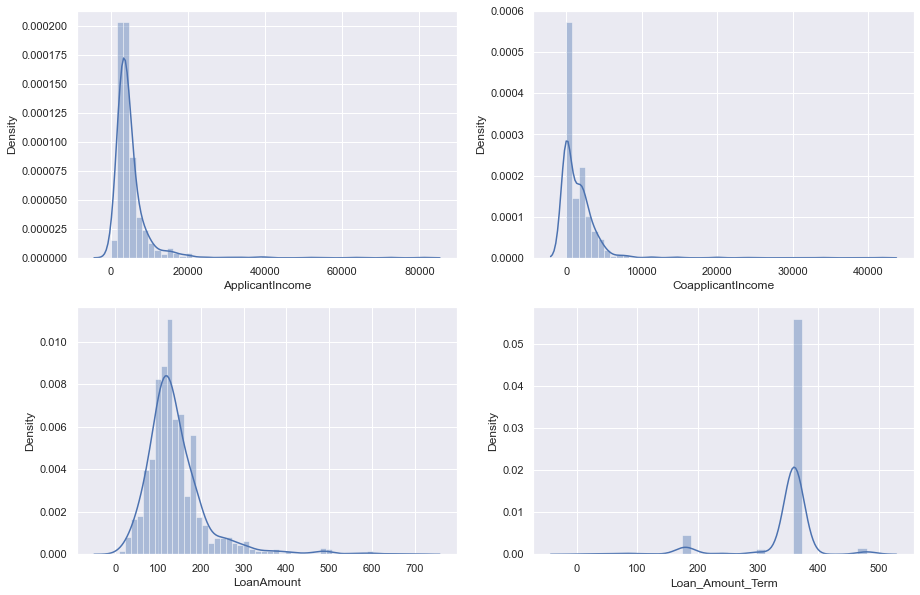

In [66]:
#Numeric Features
num_columns=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term']
for i in num_columns:
    plt.rcParams['figure.figsize']=(15,10)
    plt.subplot(2,2,num_columns.index(i)+1)
    sns.distplot(data[i]) 

All plots are skewed. So,Outliers present in all of them. We will take care of them in Feature Engineering Part.

Skewness in the ApplicantIncome maybe due to the income disparity in the society. Part of this can be driven by the fact that we are looking at people with different education levels. Let us segregate them by Education.

<AxesSubplot:xlabel='Education', ylabel='ApplicantIncome'>

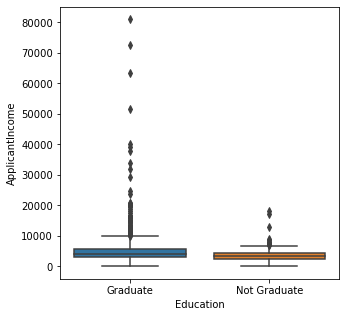

In [13]:
plt.figure(figsize=(5,5))
sns.boxplot(data['Education'],data['ApplicantIncome'])

We can see that outliers in ApplicantIncome is mainly due to different education levels of Graduates.

### ii) Categoric Features

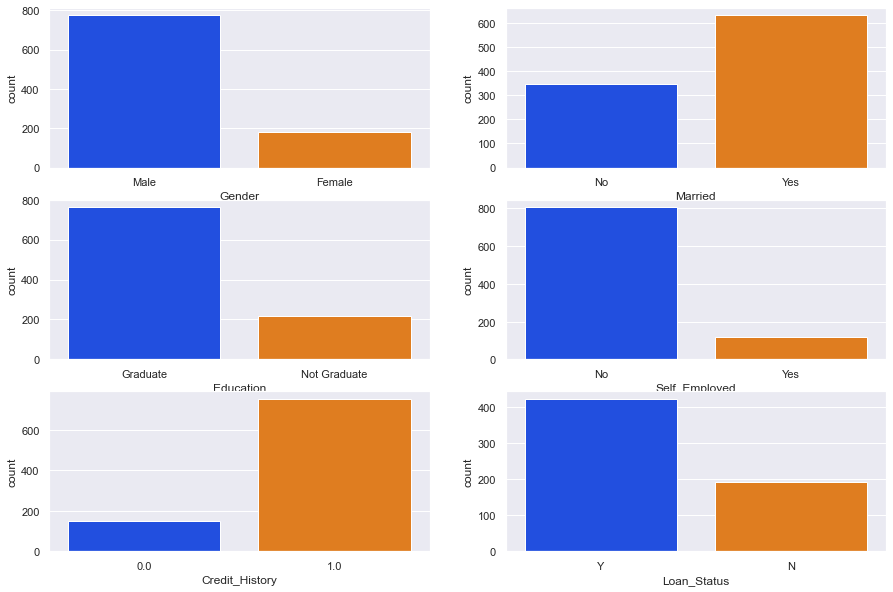

In [64]:
#categorical features
cat_columns=['Gender', 'Married', 'Education','Self_Employed','Credit_History','Loan_Status']
for i in cat_columns:
    plt.rcParams['figure.figsize']=(15,10)
    plt.subplot(3,2,cat_columns.index(i)+1)
    sns.countplot(data[i],palette='bright')

**Insights**:
1. 80% of applicants in the dataset are male.
2. Around 65% of the applicants in the dataset are married.
3. Around 80% of the applicants are Graduate.
4. Around 15% of applicants in the dataset are self-employed.
5. More than 80% of applicants have good credit_History(repaid their debts)
6. Around 70% of applicants loans are approved.

### iii) Ordinal Features

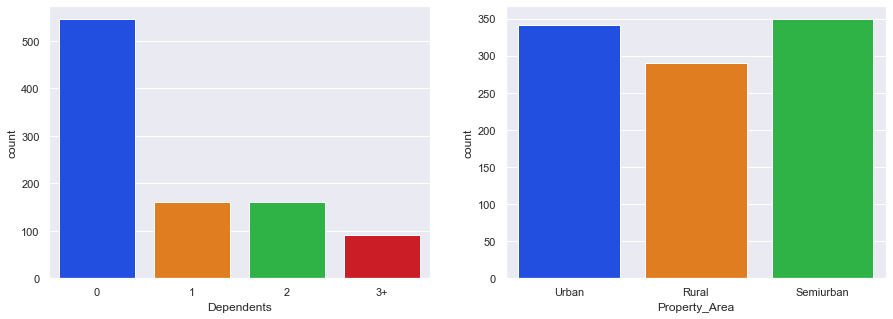

In [67]:
# Ordinal Features
ord_columns=['Dependents','Property_Area']
for i in ord_columns:
    plt.rcParams['figure.figsize']=(15,5)
    plt.subplot(1,2,ord_columns.index(i)+1)
    sns.countplot(data[i],palette='bright')

1. Most of the applicants don't have any dependents.
2. Most of the applicants are from the Semiurban area and urban area.

## B) Bivariate Analysis

### i) Numeric Features vs Target Feature

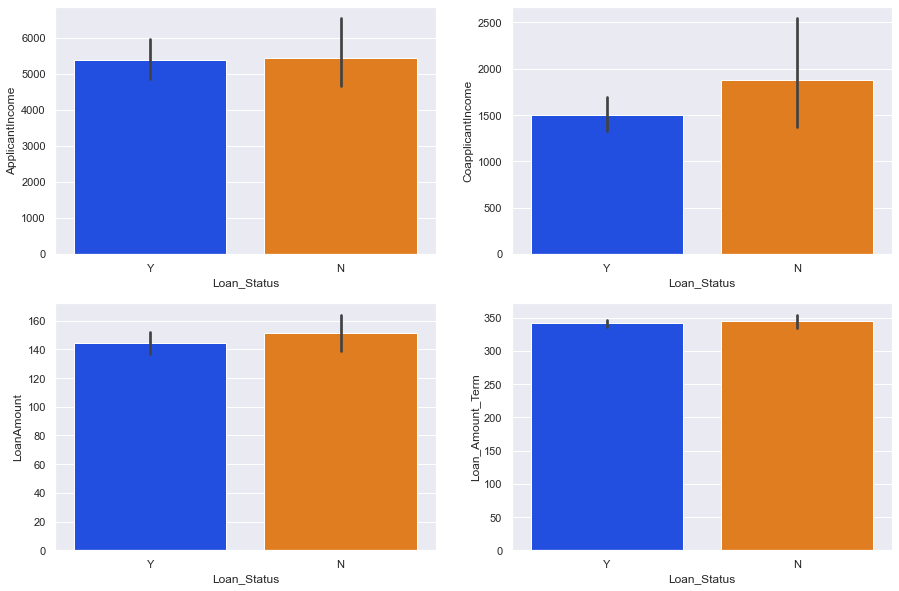

In [113]:
for i in num_columns:
    plt.rcParams['figure.figsize']=(15,10)
    plt.subplot(2,2,num_columns.index(i)+1)
    sns.barplot(data['Loan_Status'],data[i],palette='bright')

In [136]:
data.groupby('Loan_Status').mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,
N,5446.078125,1877.807292,151.220994,344.064516,0.541899
Y,5384.068720,1504.516398,144.294404,341.072464,0.981818


1. ApplicantIncome and Loan ammount term are not effecting Loan status.
2. Average CoapplicantIncome for getting a loan is 1500.
3. Less loan amount have little high chance of approvals.

### ii) Categoric Features vs Target Feature

In [92]:
g=pd.crosstab(data['Gender'],data['Loan_Status'])
g

Loan_Status,N,Y
Gender,,
Female,37,75
Male,150,339


In [93]:
g.sum(1).astype(float)

Gender
Female    112.0
Male      489.0
dtype: float64

In [94]:
#floating division of g dataframe element wise to get probability
g.div(g.sum(1).astype(float), axis=0)

Loan_Status,N,Y
Gender,,
Female,0.330357,0.669643
Male,0.306748,0.693252


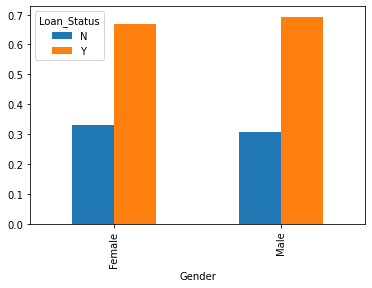

<Figure size 432x288 with 0 Axes>

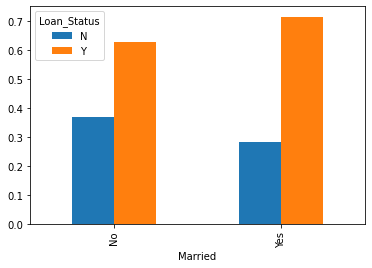

<Figure size 432x288 with 0 Axes>

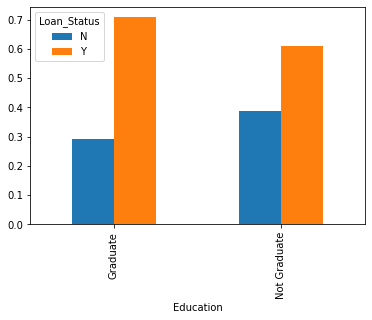

<Figure size 432x288 with 0 Axes>

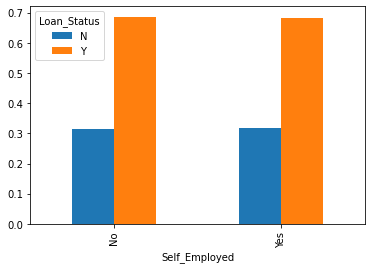

<Figure size 432x288 with 0 Axes>

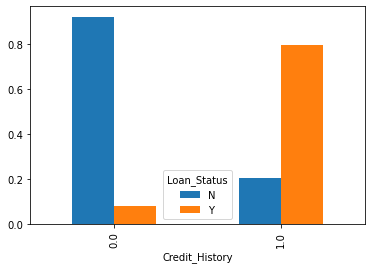

<Figure size 432x288 with 0 Axes>

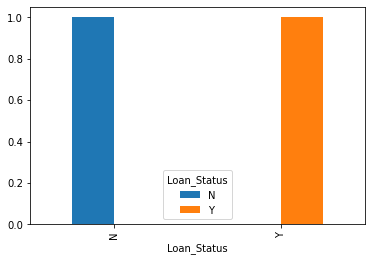

<Figure size 432x288 with 0 Axes>

In [21]:
for i in cat_columns:
    temp=pd.crosstab(data[i],data['Loan_Status'])
    temp.div(temp.sum(1).astype(float), axis=0).plot(kind='bar',figsize=(6,4))
    plt.figure()

1. Both approved and unapproved loans are same for male and female applicants.
2. Married applicants have 8% higher chance of loan approval than Unmarried.
3. Graduates have 10% higher chance loan approval than Non Graduates.
4. loan approvals is not depending on self employed.
5. Good Credit History applicants has very high(80%) chance of loan approval.

### iii) Ordinal Features vs Target Feature

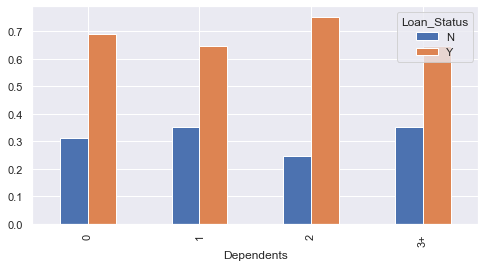

<Figure size 1080x360 with 0 Axes>

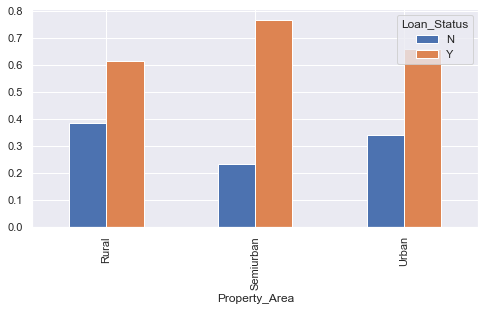

<Figure size 1080x360 with 0 Axes>

In [90]:
for i in ord_columns:
    temp=pd.crosstab(data[i],data['Loan_Status'])
    temp.div(temp.sum(1).astype(float), axis=0).plot(kind='bar',figsize=(8,4))
    plt.figure()

1. Applicants having 2 Dependents have highest(75%) chance of loan approvals.
2. Semiurban Applicants have high(78%) chance of loan approvals.

# 4. Feature Engineering

### a) Handling Missing Values

     For numerical variables: imputation using median(as there is skewess).
     For categorical variables: imputation using mode.

In [23]:
print(data['Loan_Amount_Term'].median(),'', data['Loan_Amount_Term'].mode())

360.0  0    360.0
dtype: float64


Median and Mode is same for Loan_Amount_Term.

In [24]:
data.isna().sum()

Loan_ID                0
Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
source                 0
dtype: int64

In [140]:
mode_columns=['Gender', 'Married', 'Dependents','Self_Employed','Credit_History','Loan_Amount_Term']
for i in mode_columns:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [141]:
data['LoanAmount'].fillna(data['LoanAmount'].median(),inplace=True)

In [142]:
data.isna().sum()

Loan_ID                0
Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount             0
Loan_Amount_Term       0
Credit_History         0
Property_Area          0
Loan_Status          367
source                 0
dtype: int64

### b) Handling Outliers

In [143]:
def boundaries(df, variables):
    
    Q1=df[variables].quantile(.25)
    Q3=df[variables].quantile(.75)
    IQR=Q3-Q1
    lower_boundary=Q1-1.5*IQR
    upper_boundary=Q3+1.5*IQR
    
    return lower_boundary, upper_boundary

In [144]:
def outliers(df,variables,LL,UL):
    #replacing outliers with lower and upper boundaries of IQR
    df.loc[df[variables]>=UL,variables]=UL
    df.loc[df[variables]<=LL,variables]=LL

In [145]:
out_columns=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
a=[]
for i in out_columns:
    a.append(boundaries(data,i))
a    

[(-1086.5, 9477.5), (-3547.5, 5912.5), (12.5, 248.5)]

In [146]:
i=0
while i<3:
    outliers(data,out_columns[i],a[i][0],a[i][1])
    i=i+1

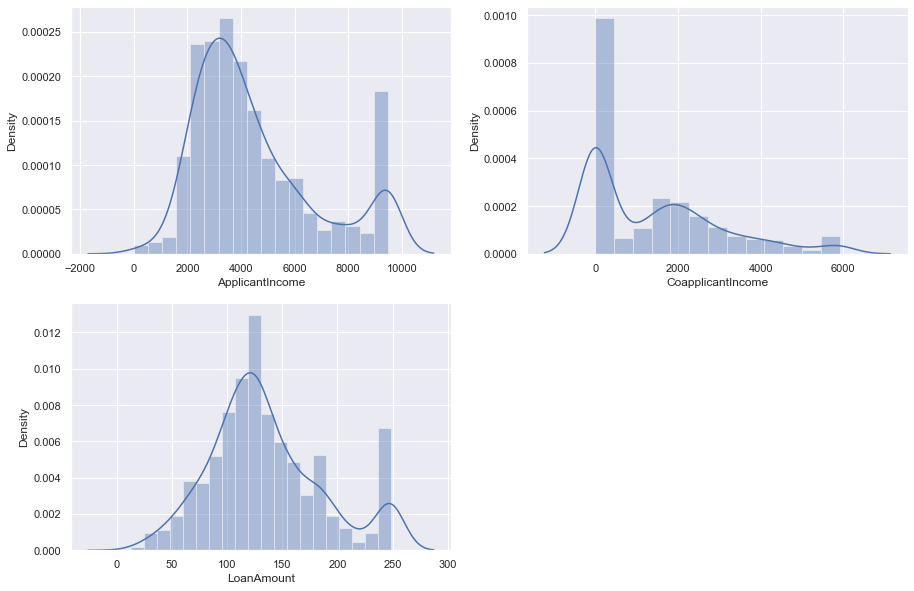

In [147]:
for i in out_columns:
    plt.rcParams['figure.figsize']=(15,10)
    plt.subplot(2,2,out_columns.index(i)+1)
    sns.distplot(data[i])

### c) Converting Categoric Features

In [148]:
# Using replace function
data.replace({'Gender':{'Female':0,'Male':1}},inplace=True)

In [149]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
data['Married']=LabelEncoder().fit_transform(data['Married'])

In [150]:
# One Hot Encoding
data=pd.get_dummies(data,columns=['Education','Self_Employed','Property_Area','Loan_Status'],drop_first=True)

In [151]:
data.head()

,Loan_ID,Gender,Married,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,source,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,LP001002,1,0,0,5849.0,0.0,126.0,360.0,1.0,train,0,0,0,1,1
1,LP001003,1,1,1,4583.0,1508.0,128.0,360.0,1.0,train,0,0,0,0,0
2,LP001005,1,1,0,3000.0,0.0,66.0,360.0,1.0,train,0,1,0,1,1
3,LP001006,1,1,0,2583.0,2358.0,120.0,360.0,1.0,train,1,0,0,1,1
4,LP001008,1,0,0,6000.0,0.0,141.0,360.0,1.0,train,0,0,0,1,1


### d) Converting dependents (3+(string) to float dtype)

In [152]:
data.Dependents.replace('3+',4,inplace=True)

In [153]:
data.Dependents.value_counts()

0    570
1    160
2    160
4     91
Name: Dependents, dtype: int64

In [154]:
data.dtypes

Loan_ID                     object
Gender                       int64
Married                      int32
Dependents                  object
ApplicantIncome            float64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
source                      object
Education_Not Graduate       uint8
Self_Employed_Yes            uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
Loan_Status_Y                uint8
dtype: object

In [155]:
#converting datatype of Dependents from object to int
data.Dependents=data.Dependents.astype(int)

In [156]:
data.dtypes

Loan_ID                     object
Gender                       int64
Married                      int32
Dependents                   int32
ApplicantIncome            float64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
source                      object
Education_Not Graduate       uint8
Self_Employed_Yes            uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
Loan_Status_Y                uint8
dtype: object

### e) Converting data to train and test datasets

In [157]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

In [158]:
test.head()

,Loan_ID,Gender,Married,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,source,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
614,LP001015,1,1,0,5720.0,0.0,110.0,360.0,1.0,test,0,0,0,1,0
615,LP001022,1,1,1,3076.0,1500.0,126.0,360.0,1.0,test,0,0,0,1,0
616,LP001031,1,1,2,5000.0,1800.0,208.0,360.0,1.0,test,0,0,0,1,0
617,LP001035,1,1,2,2340.0,2546.0,100.0,360.0,1.0,test,0,0,0,1,0
618,LP001051,1,0,0,3276.0,0.0,78.0,360.0,1.0,test,1,0,0,1,0


In [160]:
#Drop unnecessary columns:
test.drop(['Loan_Status_Y','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

Its generally a good idea to export both of these as modified data sets so that they can be re-used in other time.

In [161]:
#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

# 5. Feature Selection

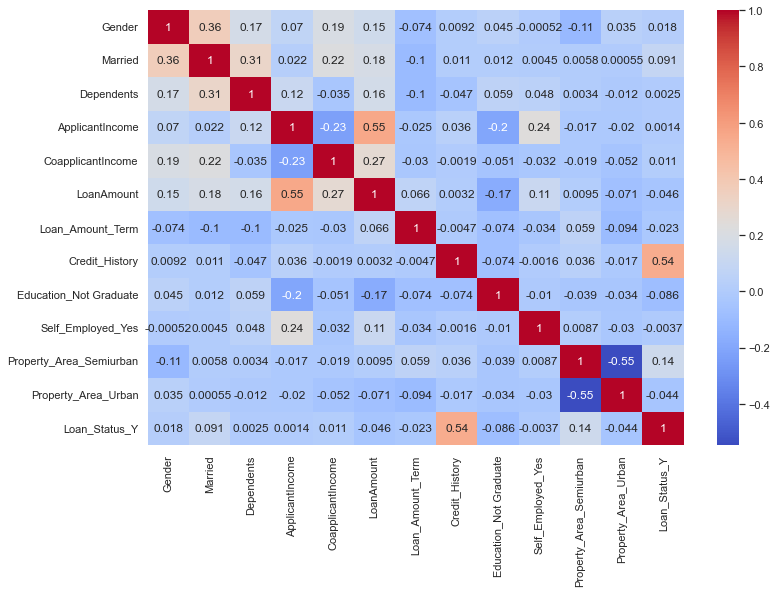

In [162]:
# Correlation Matrix
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True,cmap='coolwarm')
plt.show()

Except for ApplicantIncome,CoapplicantIncome and Self_Employed, Loan_Status has relation with all columns and as our dataset is small, lets take all features for model building.

In [163]:
train.head()

,Loan_ID,Gender,Married,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,LP001002,1,0,0,5849.0,0.0,126.0,360.0,1.0,0,0,0,1,1
1,LP001003,1,1,1,4583.0,1508.0,128.0,360.0,1.0,0,0,0,0,0
2,LP001005,1,1,0,3000.0,0.0,66.0,360.0,1.0,0,1,0,1,1
3,LP001006,1,1,0,2583.0,2358.0,120.0,360.0,1.0,1,0,0,1,1
4,LP001008,1,0,0,6000.0,0.0,141.0,360.0,1.0,0,0,0,1,1


In [48]:
x=train.drop(['Loan_Status_Y','Loan_ID'],axis=1)
y=train['Loan_Status_Y']
test_model=test.drop(['Loan_ID'],axis=1)

# 6. Model Building

### Train Test Split

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)

In [51]:
x_train.shape, x_test.shape,y_test.shape

((491, 12), (123, 12), (123,))

### a) Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
rf=RandomForestClassifier(random_state=42)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [54]:
pred_rf=rf.predict(x_test)

In [55]:
acc_rf=rf.score(x_test,y_test)
acc_rf

0.7723577235772358

In [56]:
rf.score(x_train,y_train)

0.9979633401221996

### b) XGBoost

In [57]:
from xgboost import XGBClassifier

In [58]:
xgb=XGBClassifier()
xgb.fit(x_train,y_train)

[23:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
acc_xgb=xgb.score(x_test,y_test)
acc_xgb

0.7560975609756098

In [60]:
xgb.score(x_train,y_train)

0.9979633401221996

### c) SVM

In [61]:
from sklearn.svm import SVC

In [62]:
svc=SVC()
svc.fit(x_train,y_train)

SVC()

In [63]:
acc_svc=svc.score(x_test,y_test)
acc_svc

0.6504065040650406

In [64]:
svc.score(x_train,y_train)

0.6965376782077393

### d) Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [67]:
acc_dt=dt.score(x_test,y_test)
acc_dt

0.7317073170731707

In [68]:
dt.score(x_train,y_train)

0.9979633401221996

### e) Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
lr=LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression()

In [71]:
acc_lr=lr.score(x_test,y_test)
acc_lr

0.7804878048780488

As we didn't do the standardization this may be wrong result. So,it is better not to use this.

In [72]:
lr.score(x_train,y_train)

0.8105906313645621

### f) KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier

In [74]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [75]:
acc_knn=knn.score(x_test,y_test)
acc_knn

0.5691056910569106

As we didn't do the standardization this may be wrong result. So,it is better not to use this.

In [76]:
knn.score(x_train,y_train)

0.7372708757637475

# 7. Model Selection

In [77]:
#Results of all models
Models=pd.DataFrame({'Models':['Random Forest','XGBoost','SVM','Decision Tree','Logistic Regression','KNN'],
                     'accuracy':[acc_rf,acc_xgb,acc_svc,acc_dt,acc_lr,acc_knn]})

In [78]:
Models.sort_values(by='accuracy',ascending=False)

,Models,accuracy
4,Logistic Regression,0.780488
0,Random Forest,0.772358
1,XGBoost,0.756098
3,Decision Tree,0.731707
2,SVM,0.650407
5,KNN,0.569106


As we don't want to depend on Logistic Regression(as data is not standardized). Lets use Random Forest Classifier

# 8. Hyperparameter Tuning on Random Forest

Tuning no.of estimators i.e., no.of decision trees using GridSearchCV

As the no.of trees increases accuracy also increases but after few trees this change in accuracy is insignificant.

As the no.of trees increases time complexity and cost increases.

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
params=dict(n_estimators=[100,110,120],max_depth=[2,3,4])

In [81]:
rf1=GridSearchCV(rf,param_grid=params,verbose=1)

In [82]:
%timeit
rf1.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [100, 110, 120]},
             verbose=1)

In [83]:
rf1.best_params_

{'max_depth': 2, 'n_estimators': 100}

In [84]:
rf1.best_estimator_

RandomForestClassifier(max_depth=2, random_state=42)

#### Model Evaluation

In [85]:
#Accuracy
rf1.score(x_test,y_test)

0.7886178861788617

In [86]:
y_pred=rf1.predict(x_test)

In [87]:
from sklearn.metrics import classification_report,confusion_matrix

In [88]:
confusion_matrix(y_test,y_pred)

array([[18, 25],
       [ 1, 79]], dtype=int64)

TP=79,TN=18,FP=25,FN=1

FP=25 i.e., model predicted positive but it is false.

In [89]:
pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T

,precision,recall,f1-score,support
0,0.947368,0.418605,0.580645,43.000000
1,0.759615,0.987500,0.858696,80.000000
accuracy,0.788618,0.788618,0.788618,0.788618
macro avg,0.853492,0.703052,0.719670,123.000000
weighted avg,0.825253,0.788618,0.761491,123.000000


Model's precision of those who don't get loan approval is very good.

# 9. Predicting the sales for test data

In [90]:
predicted_loan_status=rf1.predict(test_model)

In [91]:
predicted_loan_status

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [92]:
result=pd.DataFrame({'Loan_ID':test['Loan_ID'],'Predicted_loan_status':predicted_loan_status})
result.head(2)

,Loan_ID,Predicted_loan_status
614,LP001015,1
615,LP001022,1


In [93]:
#Convert them back to Y and N
result['Predicted_loan_status'].replace({1:'Y',0:'N'},inplace=True)

In [94]:
result.head(2)

,Loan_ID,Predicted_loan_status
614,LP001015,Y
615,LP001022,Y


In [95]:
#Output
result.to_csv('prediction_result.csv')